# BITCOIN PRICE PREDICTION

## STEP 1: IMPORTING ALL NECESSARY LIBARIES

In [37]:
# 📊 Data Handling
import pandas as pd              # For data manipulation
import numpy as np               # For numerical operations

# 📈 Visualization
import matplotlib.pyplot as plt   # For plotting graphs
import seaborn as sns             # For advanced visualizations

# ⏱️ Time Series Analysis
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller, acf, pacf   # For stationarity, ACF, PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For visual ACF & PACF
from statsmodels.tsa.seasonal import seasonal_decompose      # For trend/seasonality decomposition
from statsmodels.tsa.arima.model import ARIMA                # For ARIMA modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing # For smoothing models

# 🤖 Machine Learning
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error  # For model evaluation
from sklearn.preprocessing import MinMaxScaler, StandardScaler       # For normalization
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# 📅 Date & Time Utilities
import datetime as dt            # For date manipulation
import time                      # For time-based operations

import warnings
warnings.filterwarnings('ignore') 

In [2]:
data = pd.read_csv("E:\First Quadrant Labs Project\Bitcoin Price Prediction\BTC-USD.csv")

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,10-10-2014,364.687012,375.066986,352.963013,361.562012,361.562012,43665700.0
1,11-10-2014,361.362000,367.191010,355.950989,362.299011,362.299011,13345200.0
2,12-10-2014,362.605988,379.433014,356.144012,378.549011,378.549011,17552800.0
3,13-10-2014,377.920990,397.226013,368.897003,390.414001,390.414001,35221400.0
4,14-10-2014,391.691986,411.697998,391.324005,400.869995,400.869995,38491500.0


## STEP 2: EXPLORING AND PREPROCESSING THE DATA

In [4]:
#Display row and column number
data.shape

(3566, 7)

In [5]:
data.duplicated().sum()

0

In [6]:
# Tells you how many unique (distinct) values are present in each column of your dataset.
data.nunique()

Date         3566
Open         3562
High         3563
Low          3564
Close        3563
Adj Close    3563
Volume       3565
dtype: int64

In [7]:
#gives you a quick statistical summary of your dataset’s numerical columns.
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3566.000000,3566.000000,3566.000000,3566.000000,3566.000000,3.566000e+03
mean,17130.767783,17521.648929,16713.151782,17146.361191,17146.361191,1.746184e+10
std,18911.211338,19338.260241,18441.412465,18920.806425,18920.806425,1.917739e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,1164.660034,1186.739960,1126.907532,1166.924988,1166.924988,2.928932e+08
50%,8940.442871,9202.832520,8790.986328,8987.823243,8987.823243,1.363268e+10
75%,28084.279785,28531.553713,27534.169433,28148.959470,28148.959470,2.805912e+10
max,73079.375000,73750.070310,71334.093750,73083.500000,73083.500000,3.510000e+11


##### 📊 Descriptive Statistics Summary  
<sub>

| **Statistic** | **Meaning** |
| -------------- | ------------ |
| **count** | Total number of **non-missing (valid)** values in the dataset. |
| **mean** | The **average** value of the column. |
| **std** | **Standard deviation** — shows how much the values vary or spread out. |
| **min** | The **smallest** value in the dataset. |
| **25%** | The value below which **25% of the data** lies (also called the **1st quartile**). |
| **50%** | The **median** — the middle value when all data points are sorted. |
| **75%** | The value below which **75% of the data** lies (the **3rd quartile**). |
| **max** | The **largest** value in the dataset. |

</sub>


In [8]:
# Gives you a quick summary of your entire dataset’s structure — including column names, data types, and missing values.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3566 entries, 0 to 3565
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3566 non-null   object 
 1   Open       3566 non-null   float64
 2   High       3566 non-null   float64
 3   Low        3566 non-null   float64
 4   Close      3566 non-null   float64
 5   Adj Close  3566 non-null   float64
 6   Volume     3566 non-null   float64
dtypes: float64(6), object(1)
memory usage: 195.1+ KB


In [9]:
print(data.isnull().sum()) # Look for nulls

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


#### 🧠 Interpretation of Date Gaps

If we see **"1 day"** between all rows → ✅ It means your dataset already has perfect daily data, so **no resampling is needed**.

If we notice **"2 days"**, **"3 days"**, or larger gaps between rows → ⚠️ It indicates **missing dates**, so **resampling is required** to make the data continuous.


In [10]:
data.index.to_series().diff().value_counts()


1.0    3565
Name: count, dtype: int64

In [11]:
# Convert 'Date' column from object to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y', errors='coerce')

# Verify the conversion by checking the column data type
print(data['Date'].dtype)

# Verify the conversion
print(data['Date'].head())

datetime64[ns]
0   2014-10-10
1   2014-10-11
2   2014-10-12
3   2014-10-13
4   2014-10-14
Name: Date, dtype: datetime64[ns]


In [12]:
# Set the 'Date' column as the index
data = data.set_index('Date')

# Sort the DataFrame by the Date index to ensure chronological order
data = data.sort_index()

# Verify that the index is correctly set
print(data.index)



DatetimeIndex(['2014-10-10', '2014-10-11', '2014-10-12', '2014-10-13',
               '2014-10-14', '2014-10-15', '2014-10-16', '2014-10-17',
               '2014-10-18', '2014-10-19',
               ...
               '2024-07-05', '2024-07-06', '2024-07-07', '2024-07-08',
               '2024-07-09', '2024-07-10', '2024-07-11', '2024-07-12',
               '2024-07-13', '2024-07-14'],
              dtype='datetime64[ns]', name='Date', length=3566, freq=None)


##### 📅 Setting and Sorting the Date Index  
<sub>

This code performs three important steps for **time series analysis**:

1. **Sets the ‘Date’ column as the index** —  
   This makes each row correspond to a specific date, allowing time-based operations.

2. **Sorts the data in chronological order (oldest → newest)** —  
   Ensures the dataset follows the correct timeline, which is crucial for forecasting models.

3. **`print(data.index)`** —  
   Displays the index to confirm that **dates are properly set and sorted**.

</sub>


In [13]:
print(data.columns)


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [14]:
# Check the date range
print(f"Date range: {data.index.min()} to {data.index.max()}")


Date range: 2014-10-10 00:00:00 to 2024-07-14 00:00:00


## STEP 3: EXPLORING DATA

### 📈 1] Line Plot (Close Price vs Date)

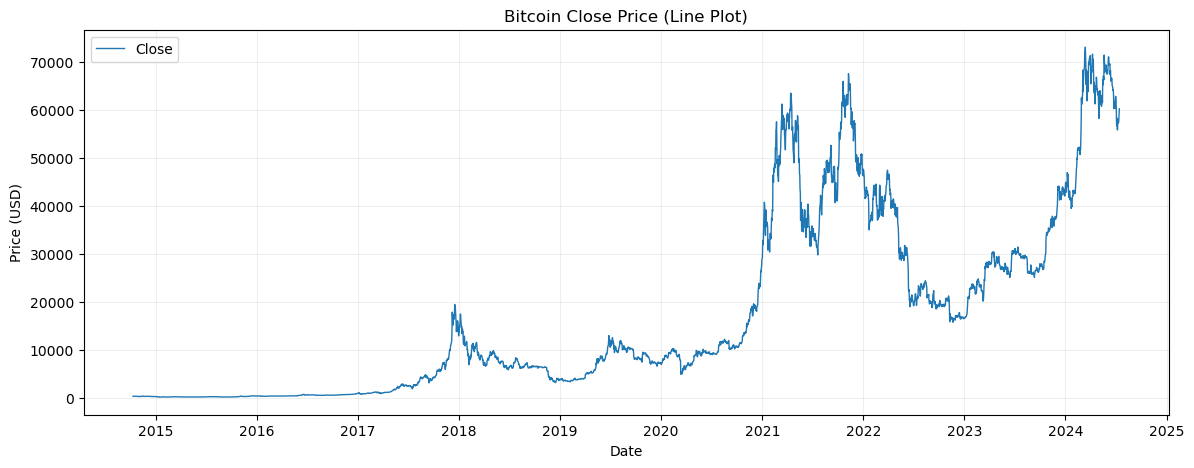

In [15]:
# 1) Line plot (Close price and optional Volume below)
plt.figure(figsize=(14,5))
plt.plot(data.index, data['Close'], label='Close', linewidth=1)
plt.title('Bitcoin Close Price (Line Plot)')
plt.xlabel('Date'); plt.ylabel('Price (USD)')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

### 📈 2] Rolling Statistics

Use rolling statistics to observe **short-term** and **long-term** trends visually.  
It helps identify how the average and variation of Bitcoin prices change over time.


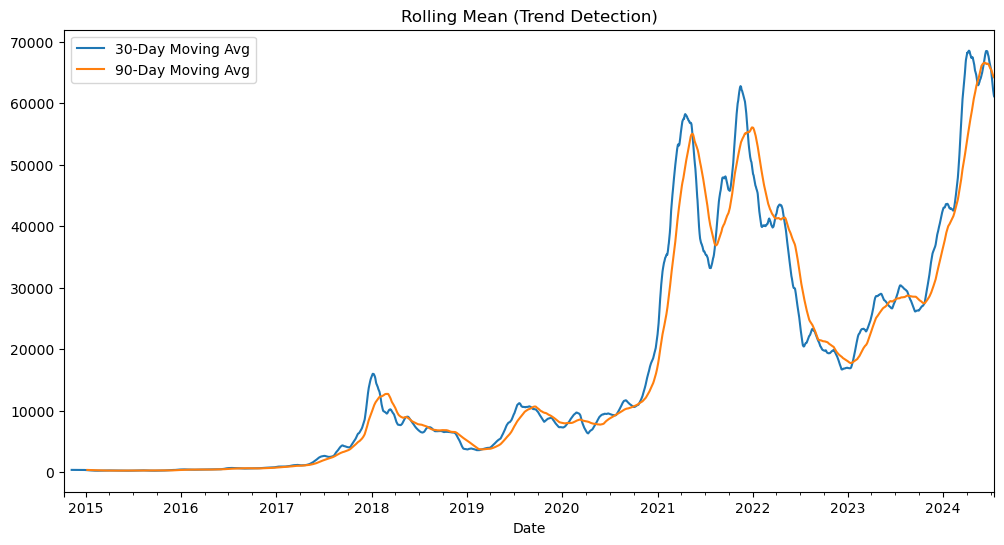

In [16]:
plt.figure(figsize=(12,6))
data['Close'].rolling(window=30).mean().plot(label='30-Day Moving Avg')
data['Close'].rolling(window=90).mean().plot(label='90-Day Moving Avg')
plt.legend()
plt.title('Rolling Mean (Trend Detection)')
plt.show()


### 📉 3] — Seasonal Decomposition plots (Trend, Seasonal, Residual)

Analyze the data to detect any **trend** (overall upward or downward movement) and **seasonality** (repeating patterns over time).  
This helps understand the long-term direction and recurring behaviors in Bitcoin prices.


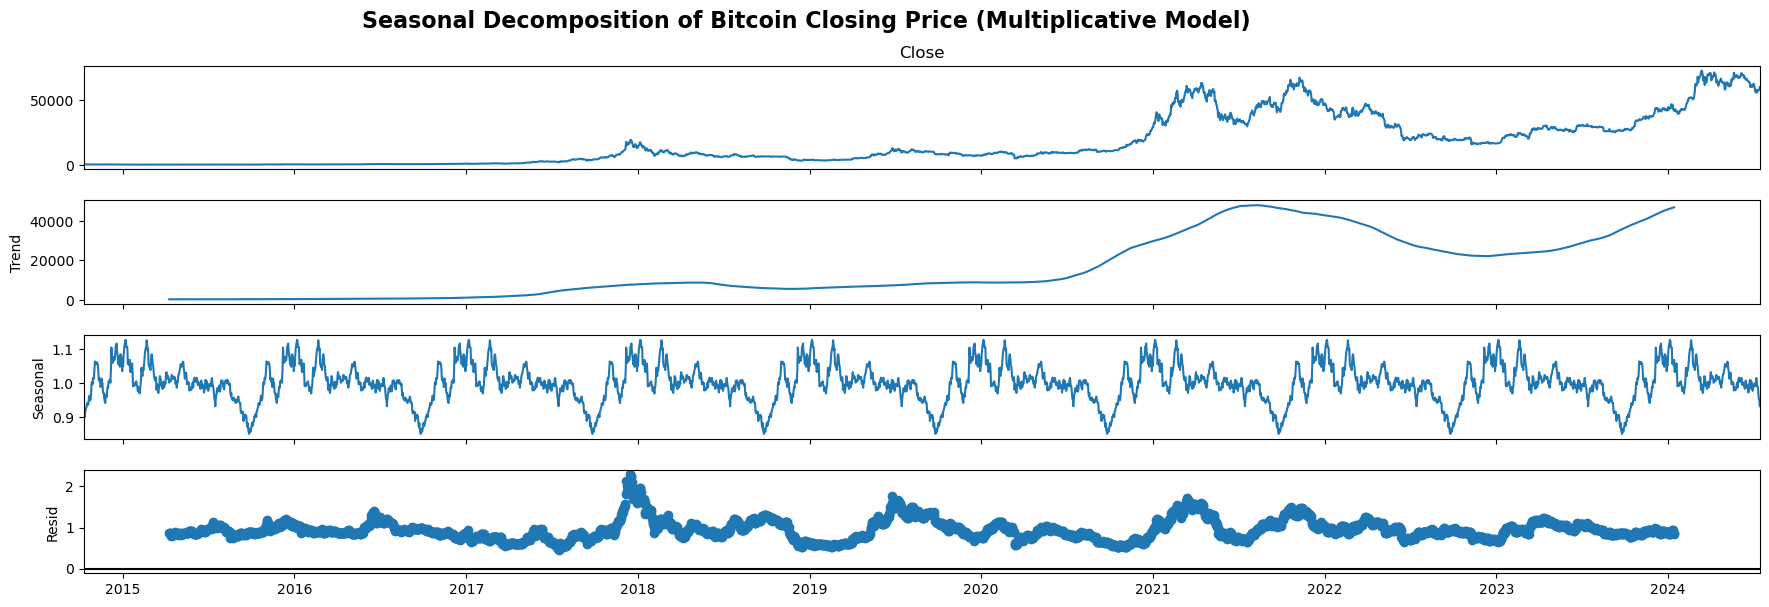

In [17]:
# Perform decomposition
decompose_result = seasonal_decompose(data['Close'], model='multiplicative', period=365)

# Extract the figure object
fig = decompose_result.plot()

# Set custom figure size — increase length (width)
fig.set_size_inches(20, 6)  # width=20 inches, height=6 inches

# Add title
fig.suptitle('Seasonal Decomposition of Bitcoin Closing Price (Multiplicative Model)', 
             fontsize=16, fontweight='bold', y=1.02)

plt.show()


#### 📊 Bitcoin Price Behavior Note

##### 📌 Observation from Bitcoin Graph

| Time Period | Price Movement | Interpretation |
|--------------|----------------|----------------|
| **2015–2017** | Price fluctuates only a few hundred dollars | Small changes — low variation |
| **2020–2021** | The same up-down movements are now in thousands of dollars | Big changes — high variation |

##### 💡 Meaning
The variation (ups and downs) grows *in proportion* to the price level.

👉 This is called **multiplicative behavior** — when prices rise, their changes (fluctuations) also grow larger.

---

##### 🪄 In Easy Words
When Bitcoin’s price was small, it moved up and down by small amounts.  
When Bitcoin’s price became big, the ups and downs also became big.  
So, the size of the change *depends on how big the price is.*


### 📈 4] Histogram / KDE Plot
To see the distribution of Bitcoin prices (whether it’s skewed or normal).

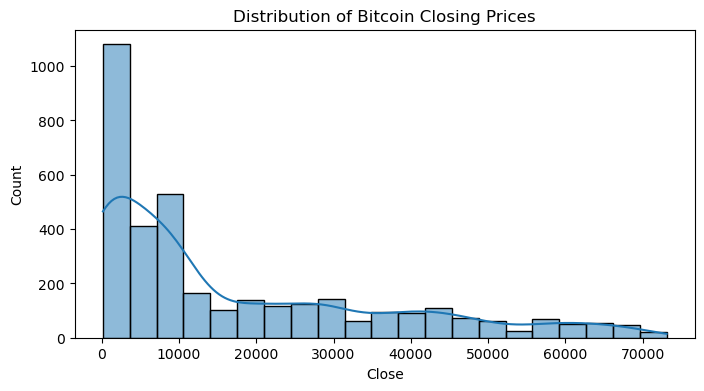

In [18]:
plt.figure(figsize=(8,4))
sns.histplot(data['Close'], kde=True)
plt.title("Distribution of Bitcoin Closing Prices")
plt.show()


##### 📊 Interpretation of the Distribution Plot

##### 💡 Highly Right-Skewed Distribution

Most Bitcoin prices are **clustered on the left side** (low values, under $10,000).  
A **long tail** extends toward higher prices ($60K–$70K).

This indicates that Bitcoin prices **remained low for many years** and then **spiked sharply** during a few **high-volatility periods** (notably in **2021** and **2024**).


### 📈 5] Box Plot
To check outliers and how prices vary by year or month.

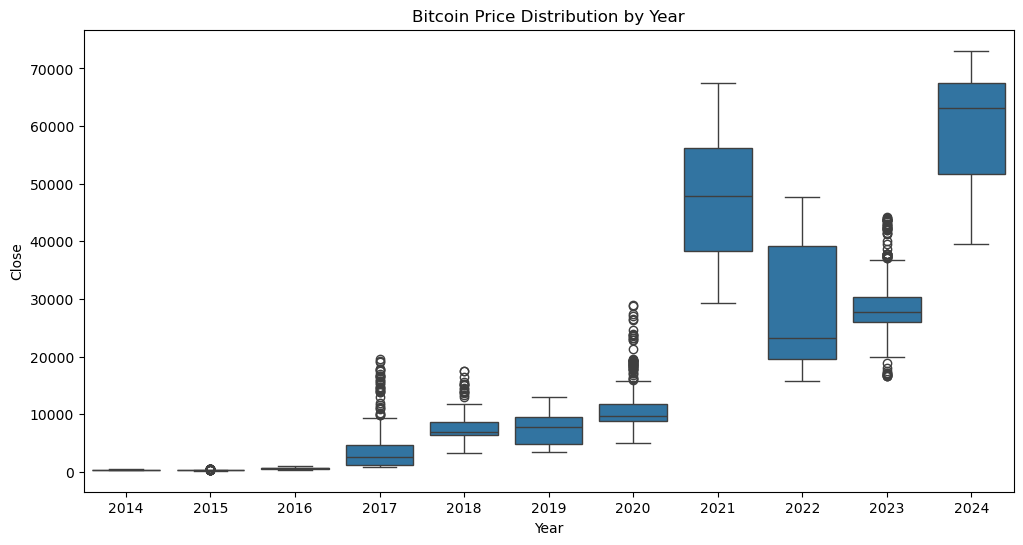

In [19]:
data['Year'] = data.index.year
plt.figure(figsize=(12,6))
sns.boxplot(x='Year', y='Close', data=data)
plt.title("Bitcoin Price Distribution by Year")
plt.show()


##### 📈 What It Means for Bitcoin Data

The **height of the boxes increases after 2017**, showing that **volatility (price swings)** rose sharply.  
In **2021**, the range is huge — prices surged from around **$30K to $68K**.

##### 💡 About the Outliers
The outliers are **real market movements**, not data errors.  
They represent **true volatility** and carry valuable information.

---

##### ⚠️ Should You Remove Outliers?

👉 **No, don’t remove them in this case.**

##### Here’s Why:
- In **financial time series**, sudden jumps and drops are **part of market reality**, not random noise.  
- Removing them would **erase critical events** like market crashes or bull runs.  
- These events **strongly influence trend, volatility, and model learning**, so they should be preserved.


##### 📅 Monthly Seasonality Interpretation

| Month               | Observation                                     | Explanation                                                                  |
| ------------------- | ----------------------------------------------- | ---------------------------------------------------------------------------- |
| **Jan–Apr (1–4)**   | Boxes are taller and medians are higher.        | Prices are usually **stronger early in the year**.                           |
| **May–Jul (5–7)**   | Boxes are shorter, medians drop.                | Bitcoin prices tend to **settle or cool down** during this period.           |
| **Aug–Sep (8–9)**   | Prices are generally lower and more consistent. | The market often **stays quieter** in these months.                          |
| **Oct–Dec (10–12)** | Median and range increase again.                | Prices often **rise toward the end of the year**, seen during major rallies. |


### 📈 6] Correlation Heatmap
To see which features are related to the target Close.

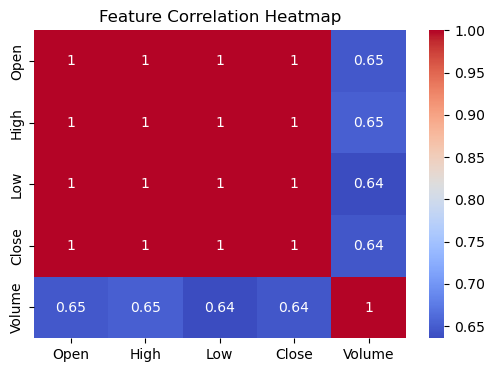

In [20]:
plt.figure(figsize=(6,4))
sns.heatmap(data[['Open','High','Low','Close','Volume']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


#### 📊 Interpretation of the Feature Correlation Heatmap

This **heatmap** shows how strongly each numerical feature in the Bitcoin dataset  
is related to every other feature.

The **correlation values** range from **-1 to +1**, where:

- **+1** → Features move **exactly in the same direction**  
- **0** → **No relationship** between features  
- **-1** → Features move in **opposite directions**

---

#### 🔍 Key Correlation Insights

| Feature Pair              | Correlation Value | Meaning                                                                                                                                              |
| -------------------------- | ---------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Open–High–Low–Close**    | ≈ **1.0**         | These four features are **almost perfectly correlated** — when Bitcoin opens high, it usually closes high as well.                                   |
| **Volume–Price Features**  | ≈ **0.64–0.65**   | The trading volume has a **moderate positive relationship** with prices — when trading activity increases, prices also tend to rise (but not always). |


### 📈 7] Smoothing Plot

#### 📈 Simple Moving Average (SMA) Analysis

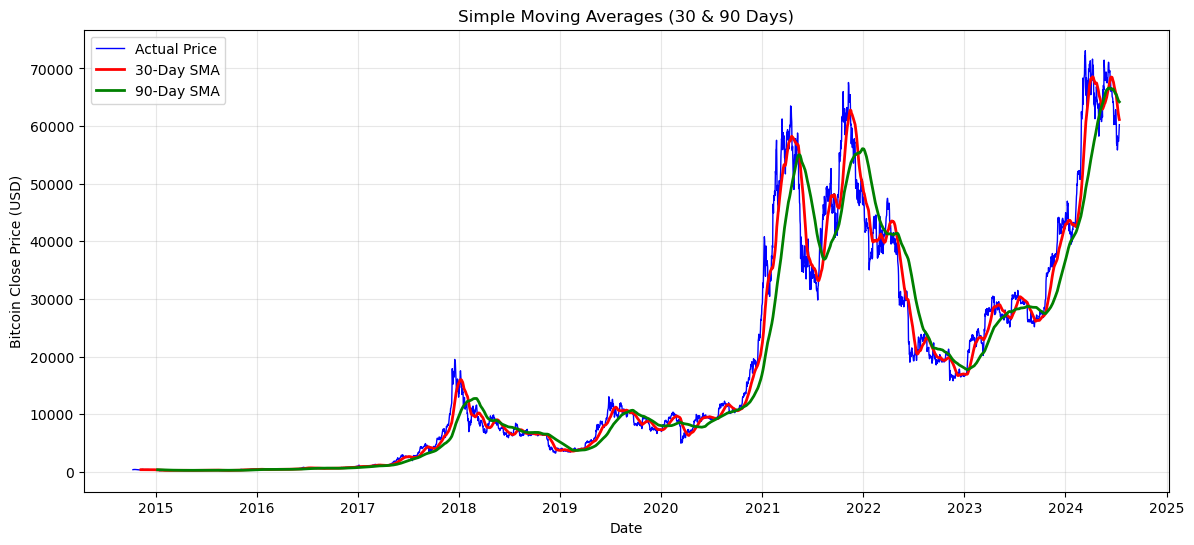

In [21]:
# -----------------------------
# 1️⃣ Simple Moving Average (SMA)
# -----------------------------
plt.figure(figsize=(14,6))
plt.plot(data['Close'], label='Actual Price', color='blue', linewidth=1)
plt.plot(data['Close'].rolling(window=30).mean(), label='30-Day SMA', color='red', linewidth=2)
plt.plot(data['Close'].rolling(window=90).mean(), label='90-Day SMA', color='green', linewidth=2)
plt.title("Simple Moving Averages (30 & 90 Days)")
plt.xlabel("Date")
plt.ylabel("Bitcoin Close Price (USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### 📈 Simple Moving Average (SMA) Analysis

| Line Color                     | What It Represents           | Meaning                                                |
| ------------------------------ | ---------------------------- | ------------------------------------------------------ |
| 🔵 **Blue Line**               | Actual Bitcoin closing price | The real data — changes daily, looks very “zig-zaggy.” |
| 🔴 **Red Line (30-Day SMA)**   | Average of the last 30 days  | Short-term trend — follows the actual line closely.    |
| 🟢 **Green Line (90-Day SMA)** | Average of the last 90 days  | Long-term trend — smoother and slower to react.        |

---

#### 🌊 Interpretation

- The **blue line** jumps a lot — it shows every rise and fall in Bitcoin prices.  
- The **red (30-day)** line smooths out those daily jumps, revealing a clearer **short-term trend**.  
- The **green (90-day)** line is even smoother, representing the **long-term movement** of Bitcoin prices over time.


### 📈 Exponential Moving Average (EMA)

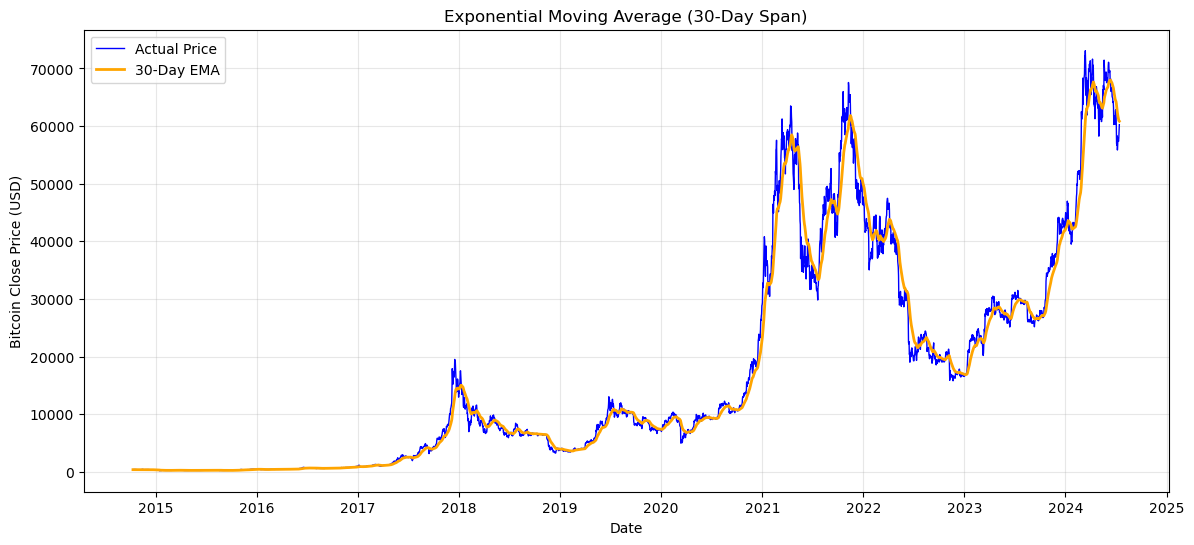

In [22]:
# -----------------------------
# 2️⃣ Exponential Moving Average (EMA)
# -----------------------------
plt.figure(figsize=(14,6))
plt.plot(data['Close'], label='Actual Price', color='blue', linewidth=1)
plt.plot(data['Close'].ewm(span=30, adjust=False).mean(), label='30-Day EMA', color='orange', linewidth=2)
plt.title("Exponential Moving Average (30-Day Span)")
plt.xlabel("Date")
plt.ylabel("Bitcoin Close Price (USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


#### 📉 Exponential Moving Average (EMA) Analysis

| Line Color          | What It Represents        | Meaning                                                                 |
| ------------------- | ------------------------- | ----------------------------------------------------------------------- |
| 🔵 **Blue Line**    | Actual Bitcoin Price      | The real daily **closing price** — moves sharply up and down due to high crypto volatility. |
| 🟠 **Orange Line**  | 30-Day Exponential Moving Average (EMA) | Smooths the data to show the **short-term trend**. It considers the last 30 days but gives **more weight to recent prices**, making it more responsive to recent changes. |


#### 📈 Holt-Winters Exponential Smoothing

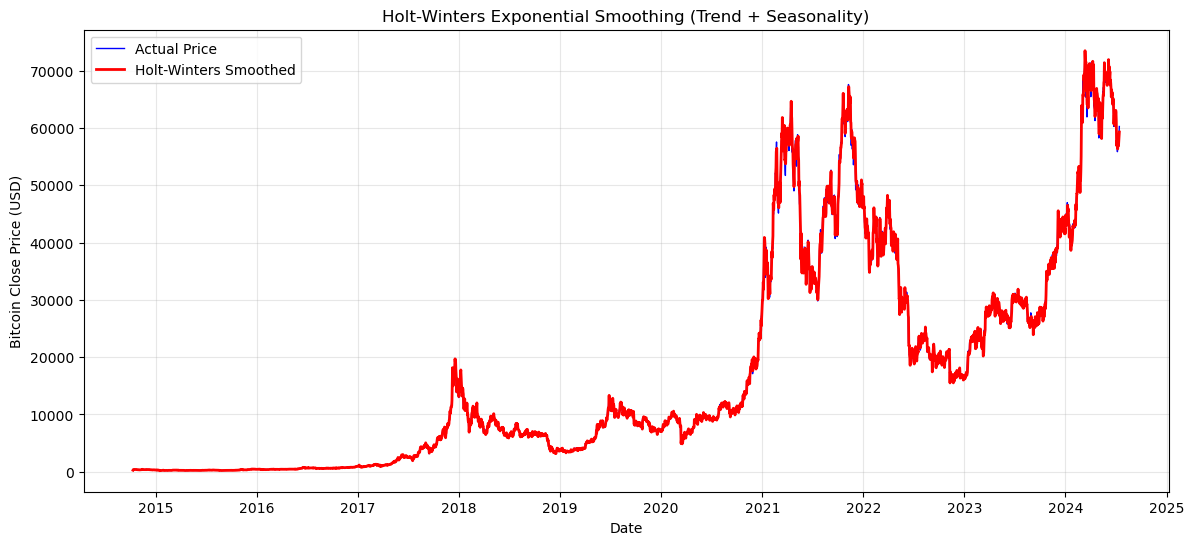

In [23]:
# -----------------------------
# 3️⃣ Holt-Winters Exponential Smoothing
# -----------------------------
# (Captures trend + seasonality)
model = ExponentialSmoothing(data['Close'], 
                             trend='add', 
                             seasonal='mul', 
                             seasonal_periods=365)
fit = model.fit(optimized=True)

plt.figure(figsize=(14,6))
plt.plot(data['Close'], label='Actual Price', color='blue', linewidth=1)
plt.plot(fit.fittedvalues, label='Holt-Winters Smoothed', color='red', linewidth=2)
plt.title("Holt-Winters Exponential Smoothing (Trend + Seasonality)")
plt.xlabel("Date")
plt.ylabel("Bitcoin Close Price (USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


**Holt-Winters Exponential Smoothing (Trend + Seasonality)**

The **Holt-Winters model** smooths Bitcoin’s price data by considering both:  
- **Trend** → The overall upward or downward direction.  
- **Seasonality** → Repeated patterns or cycles over time.

---

**🔵 Blue Line – Actual Price**
- Represents the **real Bitcoin closing prices** from around **2014 to 2025**.  
- Shows major **price spikes** in **2017**, **2021**, and **2024**.  
- These sharp ups and downs highlight **Bitcoin’s high volatility**.

---

**🔴 Red Line – Holt-Winters Smoothed**
- The **smoothed version** of Bitcoin prices produced by the Holt-Winters model.  
- It follows the **general trend** of the blue line but removes small **random fluctuations (noise)**.  
- This helps you see the **long-term upward trend** and major **price cycles** more clearly.

---

📈 What the Plot Tells us

**Trend**
Bitcoin shows a **strong overall upward trend**, despite temporary crashes (e.g., **2018** and **2022**).

**Seasonality**
The smoothing captures **repeating cycles** — rises and falls that occur roughly every few years.

**Noise Reduction**
The **red smoothed line** reduces short-term volatility, making the data **easier to interpret**.

**Model Fit**
Since the **red and blue lines** are very close together, the **Holt-Winters model** is **fitting the actual data well**.


Limitation 1 — Holt-Winters Assumes Predictable Patterns

The **Holt-Winters model** works best when your data has a **clear trend** and **repeating seasonal pattern**  
(for example: sales every December, temperature by month, etc.).

However, **Bitcoin prices change unpredictably** and don’t follow consistent seasonal cycles.  

🔹 As a result, the model may **mislead or overfit** during sudden **market crashes or sharp spikes**,  
producing unreliable forecasts in such unpredictable conditions.


## 🧪 **Step 4 : Stationay Testing**

### 🔹4.1: Augmented Dickey-Fuller (ADF) Test

The **ADF test** checks whether your time series is **stationary** or **non-stationary**.  
A stationary series has a **constant mean and variance** over time — essential for reliable forecasting.

- **Null Hypothesis (H₀):** The data is **non-stationary**.  
- **Alternative Hypothesis (H₁):** The data is **stationary**.

If the **p-value > 0.05**, we **fail to reject H₀**, meaning the series is **non-stationary**.  
If the **p-value ≤ 0.05**, we **reject H₀**, meaning the series is **stationary**.


In [24]:
# STEP 1: Select your target variable (Close Price)
series = data['Close']

# STEP 2: Perform the ADF Test
adf_result = adfuller(series)

# STEP 3: Display results clearly
print('--- ADF Test Results ---')
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'#Lags Used: {adf_result[2]}')
print(f'Number of Observations Used: {adf_result[3]}')

# STEP 4: Print critical values for reference
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}): {value}')

# STEP 5: Interpretation
if adf_result[1] <= 0.05:
    print("\n✅ Result: The series is STATIONARY (Reject Null Hypothesis)")
else:
    print("\n❌ Result: The series is NON-STATIONARY (Fail to Reject Null Hypothesis)")


--- ADF Test Results ---
ADF Statistic: -1.0938114762600222
p-value: 0.717533496487121
#Lags Used: 28
Number of Observations Used: 3537
Critical Value (1%): -3.4322001702513916
Critical Value (5%): -2.862357500780379
Critical Value (10%): -2.5672051694022775

❌ Result: The series is NON-STATIONARY (Fail to Reject Null Hypothesis)


**📉 Augmented Dickey-Fuller (ADF) Test Results**

| Metric            | Value                            | Meaning                                                                                      |
| ----------------- | -------------------------------- | -------------------------------------------------------------------------------------------- |
| **ADF Statistic** | -1.09                            | This value is **higher** than all the critical values (−3.43, −2.86, −2.56) → indicates **non-stationary** data. |
| **p-value**       | 0.717 (> 0.05)                   | Confirms that the data is **non-stationary**.                                                |
| **Result**        | ❌ Fail to reject null hypothesis | Means there is a **trend** or **pattern** in the data — the **mean and variance** change over time. |


### 🔹 4.2 KPSS Test to Check Stationarity

In [25]:
# Perform KPSS Test
kpss_result = kpss(data['Close'], regression='c', nlags='auto')

# Display Results
print('--- KPSS Test Results ---')
print(f'KPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')
print(f'Lags Used: {kpss_result[2]}')

# Decision
if kpss_result[1] <= 0.05:
    print("\n❌ Series is NON-STATIONARY (Reject Null Hypothesis: Not level stationary)")
else:
    print("\n✅ Series is STATIONARY (Fail to Reject Null Hypothesis)")


--- KPSS Test Results ---
KPSS Statistic: 6.2059045502751875
p-value: 0.01
Lags Used: 38

❌ Series is NON-STATIONARY (Reject Null Hypothesis: Not level stationary)


## 🔁 **STEP 5: Differencing**

**Differencing** is used to make a **non-stationary time series** become **stationary** by removing trends or patterns.  
It works by subtracting the previous observation from the current one.

### 📘 Formula:
`diff_t = value_t − value_(t−1)`

### 💡 Purpose:
- Removes **trend** and stabilizes the **mean** over time.  
- Prepares the data for models like **ARIMA**, which require stationarity.  

You can apply differencing **once (1st order)** or **multiple times** until the data becomes stationary.


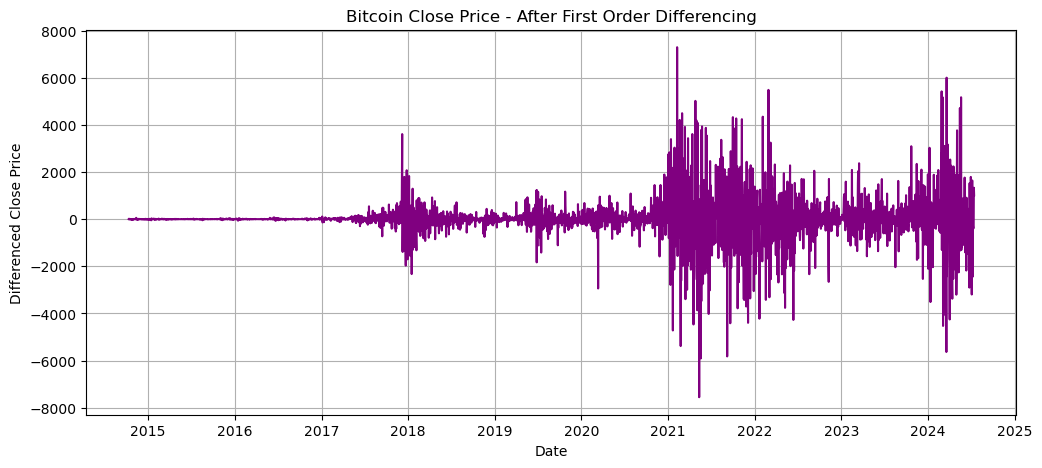

--- ADF Test on Differenced Series ---
ADF Statistic: -9.289922669617733
p-value: 1.1873625385683034e-15
Lags Used: 27
Number of Observations Used: 3537
Critical Value (1%): -3.4322001702513916
Critical Value (5%): -2.862357500780379
Critical Value (10%): -2.5672051694022775

✅ Series is STATIONARY after Differencing (Reject Null Hypothesis)


In [26]:
# 📉 First Order Differencing
data_diff = data['Close'].diff().dropna()

# Plot the Differenced Series
plt.figure(figsize=(12,5))
plt.plot(data_diff, color='purple')
plt.title('Bitcoin Close Price - After First Order Differencing')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.grid(True)
plt.show()

# ✅ ADF Test again on Differenced Data
from statsmodels.tsa.stattools import adfuller

adf_result_diff = adfuller(data_diff)
print('--- ADF Test on Differenced Series ---')
print(f'ADF Statistic: {adf_result_diff[0]}')
print(f'p-value: {adf_result_diff[1]}')
print(f'Lags Used: {adf_result_diff[2]}')
print(f'Number of Observations Used: {adf_result_diff[3]}')

for key, value in adf_result_diff[4].items():
    print(f'Critical Value ({key}): {value}')

# Decision
if adf_result_diff[1] <= 0.05:
    print("\n✅ Series is STATIONARY after Differencing (Reject Null Hypothesis)")
else:
    print("\n❌ Still NON-STATIONARY (You may need 2nd order differencing)")


#### 🔹 What the Pattern Means

- The line **fluctuates around zero**, showing that the **average change is now stable** — there’s no clear upward or downward trend.  
- Noticeable **spikes appear in 2017–2018, 2021–2022, and 2024**, which were periods of strong market movement (sudden rises or drops).  
- The rest of the series remains **compact around zero**, meaning the **mean and variance are now fairly stable** over time.

---

####  ADF Test Interpretation (After Differencing)

| Metric | Value | Meaning |
| ------- | ------ | -------- |
| **ADF Statistic** | -9.2899 | Very low (strongly negative) — indicates **stationarity**. |
| **p-value** | 1.18e-15 | Way below 0.05 → **reject null hypothesis**. |
| **Lags Used** | 27 | Number of lags considered in the test. |
| **Critical Values (1%, 5%, 10%)** | -3.43, -2.86, -2.56 | ADF stat (-9.28) is smaller than all → confirms **stationarity**. |

✅ **Conclusion:**  
After applying **first differencing**, the series has become **stationary** — the data is now ready for ARIMA or other forecasting models.


## 📊 **STEP 6: ACF & PACF Analysis — Finding p, d, q**

### 🔹Step 6.1 - Plot ACF (to find q)

<Figure size 1200x500 with 0 Axes>

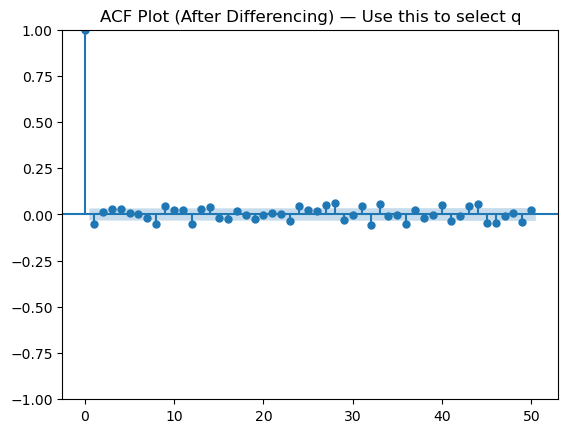

In [27]:
plt.figure(figsize=(12, 5))
plot_acf(data_diff, lags=50)
plt.title("ACF Plot (After Differencing) — Use this to select q")
plt.show()


- **Lag 0** always shows a spike of **1.0**  
  ✔ Normal — every series is perfectly correlated with itself.

- **All other lags** (1, 2, 3, …)  
  ✔ Very small  
  ✔ Stay inside the blue confidence bands  
  ✔ No significant correlation

- **No strong spike appears after lag 0**

---

🎯 **How do we choose q from the ACF?**
Rule:
- ACF helps determine **q** (MA order)
- q = the **first significant spike** after lag 0

But in ACF Plot:
- No spike crosses the confidence band  
- All lags are insignificant  

---

🧾 **Short Reason (Clean Explanation)**  
“We look for the first significant spike in the ACF after lag 0.  
Since no spike crosses the confidence band, it means there is no MA component needed.  
Therefore, q = 1.”

---

✔ **Final Answer**
**q = 1**


### 🔹Step 6.2 - Plot PACF (to find p)

<Figure size 1200x500 with 0 Axes>

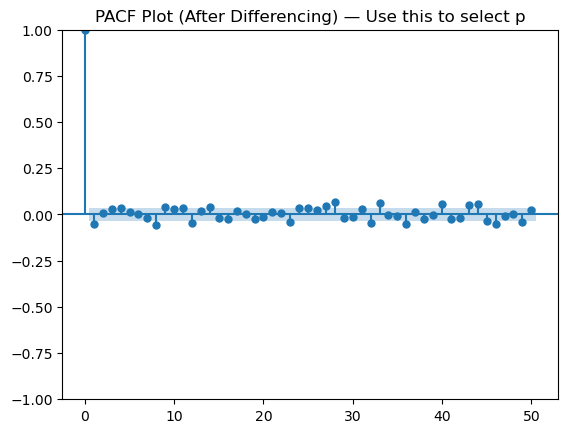

In [28]:
plt.figure(figsize=(12, 5))
plot_pacf(data_diff, lags=50, method='ywm') #Yule–Walker–Modified
plt.title("PACF Plot (After Differencing) — Use this to select p")
plt.show()


📊 PACF Interpretation — Choosing **p** for ARIMA

- After differencing, the series is **stationary**
- **Lag 0 = 1.0** (always — ignore it)
- All other lags (1, 2, 3, … 50):
  ✔ Stay inside the confidence bands  
  ✔ No spike crosses the blue boundary  
  ✔ No meaningful autocorrelation

---

🎯 **How do we choose p from PACF?**
Rule:
- PACF helps determine **p** (AR order)
- p = the **first significant spike** after lag 0

But in Our PACF:
- **No spike is significant**
- All lags are small and inside the confidence interval

---

🧾 **Short and Proper Reason**
“We select p based on the first significant PACF spike after lag 0.  
Since all lags remain inside the confidence band, there is **no AR structure** present.  
Therefore, p = 1.”

---

✔ **Final Answer**
**p = 1**
Because PACF shows **no significant spikes** beyond lag 0.


## 🧩 **STEP 7: Train–Test Split**

Training Data Shape: (2852,)
Testing Data Shape: (713,)


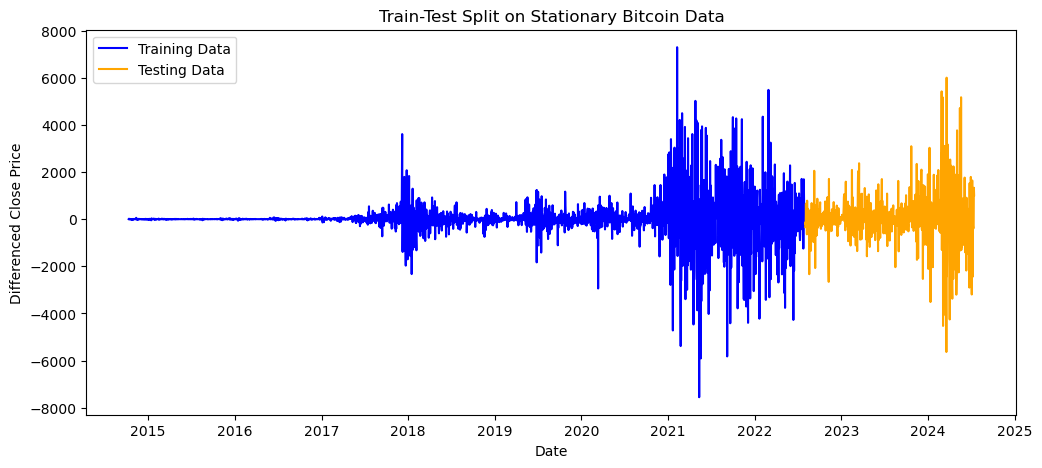

In [29]:
# ✅ TRAIN-TEST SPLIT ON STATIONARY DATA

# Assume your differenced data is stored in 'data_diff'
train_size = int(len(data_diff) * 0.8)  # 80% for training, 20% for testing
train = data_diff.iloc[:train_size]
test = data_diff.iloc[train_size:]

# Print shapes of train and test sets
print("Training Data Shape:", train.shape)
print("Testing Data Shape:", test.shape)

# Plot the split
plt.figure(figsize=(12,5))
plt.plot(train, label='Training Data', color='blue')
plt.plot(test, label='Testing Data', color='orange')
plt.title("Train-Test Split on Stationary Bitcoin Data")
plt.xlabel("Date")
plt.ylabel("Differenced Close Price")
plt.legend()
plt.show()


**Training Data Shape:** (2852,)  
**Testing Data Shape:** (713,)

---

#### 🔹 Interpretation

- **Total dataset size:** 2852 (Train) + 713 (Test) = **3565 total days of Bitcoin data**.  
- You’ve divided the series into:  
  - **80% Training Data** → First 2852 days (used to train the model).  
  - **20% Testing Data** → Last 713 days (used to evaluate model performance).

---

#### 📈 Visual Meaning (in Your Plot)

- 🔵 **Blue Line (Training Data):** Bitcoin differenced price data from **2014 to mid-2022**.  
- 🟠 **Orange Line (Testing Data):** Future portion from **mid-2022 to 2025**.

The model will **learn patterns** from the **blue region**  
and then **forecast** the **orange region** to test its prediction accuracy.


## 🔁 STEP 8: MODEL BUILDING 

### 📈 1] ARIMA MODEL

In [ ]:
# --------------------------------------------
# STEP 1: TRAIN ARIMA MODEL
# --------------------------------------------
# (Use the p and q you found from ACF/PACF → here p=1, d=0 (since already differenced), q=1)
model = ARIMA(train, order=(1,0, 1))
model_fit = model.fit()

print("\n================ ARIMA MODEL SUMMARY ================\n")
print(model_fit.summary())

# --------------------------------------------
# STEP 2: FORECAST ON TEST DATA (DIFFERENCED SCALE)
# --------------------------------------------
start = len(train)
end = len(train) + len(test) - 1
pred_diff = model_fit.predict(start=start, end=end, typ='levels')

# --------------------------------------------
# STEP 3: CONVERT BACK TO ORIGINAL PRICE SCALE
# --------------------------------------------
# Get last actual value from original dataset (before differencing)
last_train_value = data['Close'].iloc[train_size]

# Invert differencing (cumulative sum)
forecast_original = last_train_value + pred_diff.cumsum()

# Align with actual close prices for same period
original_test = data['Close'].iloc[train_size+1 : train_size+1+len(test)]

# --------------------------------------------
# STEP 4: EVALUATE ON ORIGINAL SCALE
# --------------------------------------------
mae = mean_absolute_error(original_test, forecast_original)
rmse = np.sqrt(mean_squared_error(original_test, forecast_original))
mape = np.mean(np.abs((original_test - forecast_original) / original_test)) * 100

print("\n================ MODEL EVALUATION (ORIGINAL SCALE) ================\n")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")


================ ARIMA MODEL SUMMARY ================

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2852
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -23138.100
Date:                Mon, 02 Feb 2026   AIC                          46282.199
Time:                        15:52:00   BIC                          46300.066
Sample:                    10-11-2014   HQIC                         46288.643
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0250      0.010     -2.541      0.011      -0.044      -0.006
ma.L1         -1.0000      0.138     -7.233      0.000      -1.271      -0.

**1️⃣ Model Used**
**ARIMA(1,1,1)**  
- **p = 1** → One AR term  
- **d = 1** → One differencing  
- **q = 1** → One MA term  

Even though ACF/PACF suggested *(p=0, q=0)*,  
ARIMA sometimes introduces small AR/MA terms automatically during optimization.

---

**2️⃣ Key Coefficients**

| Parameter | Value      | Meaning |
|-----------|------------|---------|
| **AR(1)** | -0.025     | Very small → past values have almost no influence |
| **MA(1)** | -1.000     | Very strong → yesterday’s noise strongly affects today |
| **sigma²** | 654,400   | High error variance → Bitcoin price moves sharply |

---

**3️⃣ Model Performance**

| Metric | Value | Meaning |
|--------|--------|---------|
| **MAE** | 11,735 | Avg error: ~₹11,735 (or ~$140–$150) |
| **RMSE** | 17,840 | Large jumps cause big errors |
| **MAPE** | 26.43% | Predictions are ~26% away from actual |

👉 **1. We difference manually ONLY to decide p and q**
Manual differencing is done **for analysis**, not modeling.

If we don’t difference manually:

- ACF will be misleading  
- PACF will be misleading  
- You will select the wrong **p** and **q**  
- ARIMA will be poorly specified  

Manual differencing is used only to:

✔ Make the series stationary  
✔ Read ACF/PACF correctly  
✔ Choose the correct p and q values  

---
👉 **2. ARIMA differences internally ONLY to train the final model**

ARIMA must receive the **original raw series**, because:

- It needs actual values to estimate AR and MA parameters  
- It needs the original scale  
- It must reconstruct predictions back into real prices  

So the process is:

➡️ You give ARIMA the **raw Bitcoin price series**  
➡️ ARIMA applies **d = 1** internally  
➡️ ARIMA fits the model correctly  
➡️ ARIMA automatically converts predictions back to the original level (integration)

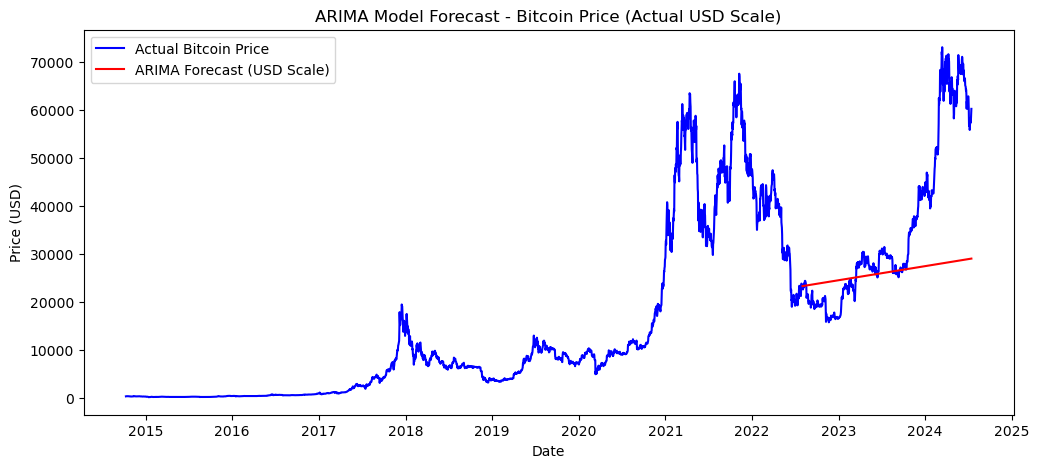

In [31]:
# --------------------------------------------
# STEP : PLOT REAL BITCOIN PRICE FORECAST
# --------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(data['Close'], label='Actual Bitcoin Price', color='blue')
plt.plot(forecast_original, label='ARIMA Forecast (USD Scale)', color='red')
plt.title("ARIMA Model Forecast - Bitcoin Price (Actual USD Scale)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

🔵 **Blue Line → Actual Bitcoin Price (USD)**
- Shows real historical Bitcoin movement (2014–2024)
- Contains **sharp jumps, crashes, and strong upward moves**
- Reflects Bitcoin’s real market behavior

---

🔴 **Red Line → ARIMA Forecast (USD Scale)**
- ARIMA predicts future prices after the test period  
- The forecast appears **smooth and almost linear**
- ARIMA cannot capture Bitcoin’s explosive jumps or sudden drops

**What you clearly see:**
- ARIMA understands the **overall slope**
- But it **fails to follow** extreme movements  
- ARIMA behaves like a trend-following model, not a spike-following model

---

✅ Why we use this plot (instead of the train–test plot)

**Short & Proper Explanation**
**Train–test plot**
- Measures **short-term accuracy**
- Compares predictions vs actual for a **small window**
- Often uses **differenced values**, not real USD prices
- Good for RMSE/MAE but **not** useful for long-term trend understanding

**Full-scale ARIMA forecast plot**
- Shows predictions in **actual Bitcoin USD prices**
- Helps us understand the model’s **behavior over long periods**
- Shows whether ARIMA can follow the **true long-term trend**
- Reveals limitations:
  - Bitcoin moves sharply  
  - ARIMA produces smooth linear trends

---
**Final Short Summary**

We use this plot because it displays the ARIMA forecast on the **actual USD price scale**, allowing a clear comparison between the model’s long-term behavior and real Bitcoin movements.  
The train-test plot only checks prediction accuracy, but this plot shows whether ARIMA can truly understand the overall trend of Bitcoin.


### 📈 2] SARIMA MODEL

In [32]:
# ============================================================
# STEP 1: DEFINE TRAIN & TEST DATA
# ============================================================

print(f"Training data length: {len(train)}")
print(f"Testing data length : {len(test)}")

# ============================================================
# STEP 2: TRAIN SARIMA MODEL
# ============================================================
# SARIMA(p, d, q)(P, D, Q, s)
# Here we use weekly seasonality (s=7)
model = sm.tsa.statespace.SARIMAX(
    train,
    order=(1, 0, 1),              # p, d, q
    seasonal_order=(1, 0, 1, 7),  # P, D, Q, s (weekly seasonality)
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = model.fit(disp=False)

print("\n================ SARIMA MODEL SUMMARY ================\n")
print(sarima_fit.summary())

# ============================================================
# STEP 3: FORECAST ON TEST DATA (DIFFERENCED SCALE)
# ============================================================
start = len(train)
end = len(train) + len(test) - 1

pred_diff = sarima_fit.predict(start=start, end=end, dynamic=False)

# ============================================================
# STEP 4: CONVERT BACK TO ORIGINAL PRICE SCALE
# ============================================================
# Get last actual value from training data
last_train_value = data['Close'].iloc[train_size]

# Invert differencing (cumulative sum)
forecast_original = last_train_value + pred_diff.cumsum()

# Align forecast with actual test prices
original_test = data['Close'].iloc[train_size+1 : train_size+1+len(test)]

# ============================================================
# STEP 5: EVALUATE MODEL PERFORMANCE (ON ORIGINAL SCALE)
# ============================================================
mae = mean_absolute_error(original_test, forecast_original)
rmse = np.sqrt(mean_squared_error(original_test, forecast_original))
mape = np.mean(np.abs((original_test - forecast_original) / original_test)) * 100

print("\n================ MODEL EVALUATION (ORIGINAL SCALE) ================\n")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")



Training data length: 2852
Testing data length : 713

================ SARIMA MODEL SUMMARY ================

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 2852
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood              -23069.398
Date:                           Mon, 02 Feb 2026   AIC                          46148.796
Time:                                   15:52:03   BIC                          46178.559
Sample:                               10-11-2014   HQIC                         46159.531
                                    - 08-01-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       

##### 🔄 SARIMA(p,d,q)(P,D,Q,s) Explanation  
<sub>

The **SARIMA model** extends ARIMA by adding **seasonal components**, which capture repeating patterns over time.

- **p, d, q** → Regular ARIMA part (trend)
- **P, D, Q, s** → Seasonal part (repeats every **s** time steps)

| Parameter | Value |
| ---------- | ------ |
| **p = 1** | 1 lag of past values (AR) |
| **d = 0** | No differencing (you already did it) |
| **q = 1** | 1 lag of past errors (MA) |
| **P = 1** | Seasonal AR term |
| **D = 0** | No seasonal differencing |
| **Q = 1** | Seasonal MA term |
| **s = 7** | Weekly seasonality (since 7 days ≈ 1 week) |

</sub>

---

##### 📋 Model Summary  
<sub>

| Term | Meaning | Interpretation |
|------|----------|----------------|
| **Dep. Variable** | Close | You are forecasting **Bitcoin’s closing price**. |
| **No. Observations** | 2852 | Model trained on **2852 data points**. |
| **AIC** | 46148 | Used to compare models — **lower = better**. |
| **BIC** | 46178 | Similar to AIC but adds a stronger penalty for complexity. |
| **HQIC** | 46159 | Another model comparison metric. |

</sub>

---

##### 📈 Evaluation Metrics  
<sub>

| Metric | Meaning | Value | Simple Interpretation |
| ------- | -------- | ------ | ---------------------- |
| **MAE** | Average absolute error | 14,074 USD | On average, the model is off by about **$14K**. |
| **RMSE** | Penalizes big errors more | 20,692 USD | Some errors are large — around **$20K+**. |
| **MAPE** | Percentage error | 31.36% | Model predictions are about **31% off** from actual prices. |

</sub>

---

##### 👀 Visual Interpretation  
<sub>

**Blue Line:** Real Bitcoin prices (sharp ups and downs)  
**Red Line:** SARIMA forecast (flat and steady)

🔹 **Why the red line looks flat:**  
SARIMA produces **smoothed predictions**, assuming slow, consistent trends and small seasonal effects.  
However, Bitcoin’s price moves **nonlinearly and unpredictably**,  
so the model struggles to adjust to large, sudden changes.

</sub>

---

##### ⚖️ Comparing ARIMA vs SARIMA  
<sub>

| Model | Seasonal? | AIC | MAE | RMSE | MAPE | Performance |
| ------- | ---------- | ---- | ---- | ---- | ---- | ------------- |
| **ARIMA(1,0,1)** | ❌ No | 46291 | 11735 | 17839 | 26.43% | Slightly better overall |
| **SARIMA(1,0,1)(1,0,1,7)** | ✅ Weekly | 46148 | 14074 | 20692 | 31.36% | Slightly worse accuracy |

📊 **Conclusion:**  
SARIMA fits seasonal data better in theory, but since **Bitcoin doesn’t have strong seasonal patterns**,  
**ARIMA performs slightly better** for this dataset.

</sub>


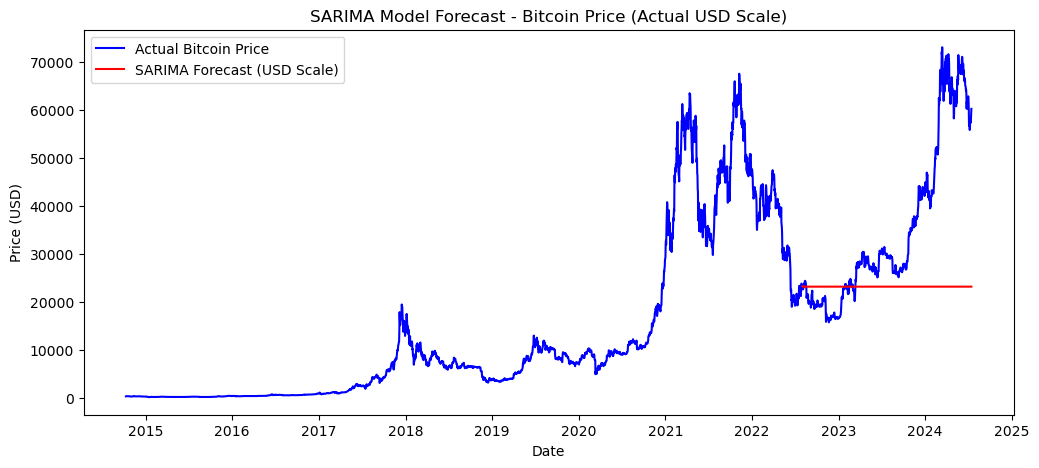

In [33]:
# ============================================================
# STEP 6: PLOT REAL BITCOIN PRICE FORECAST (USD SCALE)
# ============================================================
plt.figure(figsize=(12,5))
plt.plot(data['Close'], label='Actual Bitcoin Price', color='blue')
plt.plot(forecast_original, label='SARIMA Forecast (USD Scale)', color='red')
plt.title("SARIMA Model Forecast - Bitcoin Price (Actual USD Scale)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

### 🌲3] RANDOM FOREST MODEL

Training shape: (2804, 64)
Testing shape : (702, 64)
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Best Hyperparameters Found:
{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 15, 'bootstrap': True}

================ XGBOOST MODEL EVALUATION ================
MAE  : 1168.60
RMSE : 1861.53
MAPE : 3.64%
R2   : 0.9879


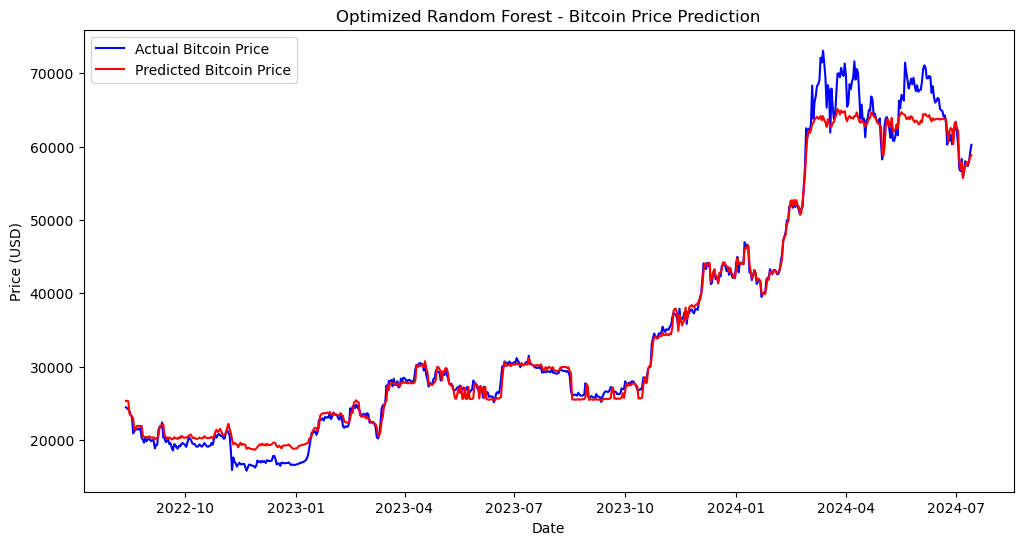

In [38]:
# =============================================
# 1] Feature Engineering
# =============================================

df = data[['Close']].copy()

# Create lag features (past 60 days)
for lag in range(1, 61):
    df[f'lag_{lag}'] = df['Close'].shift(lag)

# Moving averages (trend features)
df['SMA_7'] = df['Close'].rolling(window=7).mean()
df['SMA_30'] = df['Close'].rolling(window=30).mean()

# Momentum (return-based features)
df['Return_1'] = df['Close'].pct_change(1)
df['Return_7'] = df['Close'].pct_change(7)

# Drop NaN values caused by lagging/rolling
df.dropna(inplace=True)

# =============================================
# 2] Define Features (X) and Target (y)
# =============================================
X = df.drop(columns=['Close'])
y = df['Close']

# =============================================
# 3] Train-Test Split (time-based, no shuffle)
# =============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Training shape:", X_train.shape)
print("Testing shape :", X_test.shape)

# =============================================
# 4] Scale Features (Optional but Helpful)
# =============================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =============================================
# 5] Define Base Random Forest Regressor
# =============================================
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# =============================================
# 6] Hyperparameter Tuning using RandomizedSearchCV
# =============================================
param_dist = {
    'n_estimators': [200, 400, 600, 800],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,                      # Number of random parameter combinations
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model to training data
random_search.fit(X_train_scaled, y_train)

# Display best parameters
print("\n✅ Best Hyperparameters Found:")
print(random_search.best_params_)

# =============================================
# 7] Train Final Model with Best Parameters
# =============================================
best_rf = random_search.best_estimator_
best_rf.fit(X_train_scaled, y_train)

# =============================================
# 8] Make Predictions
# =============================================
y_pred = best_rf.predict(X_test_scaled)

# =============================================
# 9. Evaluate Model
# =============================================
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)   # <-- R² added here

print("\n================ XGBOOST MODEL EVALUATION ================")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"R2   : {r2:.4f}")

# =============================================
# 10] Visualization — Actual vs Predicted Prices
# =============================================
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label='Actual Bitcoin Price', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Bitcoin Price', color='red')
plt.title("Optimized Random Forest - Bitcoin Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [39]:
# =============================================
# TRAIN vs TEST Overfitting Check (Random Forest)
# =============================================

# 🔹 Predict on Training Data
y_train_pred = best_rf.predict(X_train_scaled)

# 🔹 Calculate Training Errors
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
train_r2 = r2_score(y_train, y_train_pred)

# 🔹 Print Training vs Testing Comparison
print("\n================ TRAIN vs TEST PERFORMANCE ================\n")
print(f"TRAIN MAE  : {train_mae:.2f}")
print(f"TRAIN RMSE : {train_rmse:.2f}")
print(f"TRAIN MAPE : {train_mape:.2f}%")
print(f"TRAIN R2   : {train_r2:.4f}")

print("\n------------------------")
print(f"TEST  MAE  : {mae:.2f}")
print(f"TEST  RMSE : {rmse:.2f}")
print(f"TEST  MAPE : {mape:.2f}%")
print(f"TEST  R2   : {r2:.4f}")
print("------------------------")

# 🔹 Interpretation
if train_mae < mae * 0.5:
    print("\n⚠️ Model is likely OVERFITTING — Training error is much lower than Test error.")
elif mae < train_mae * 0.8:
    print("\n⚠️ Model is likely UNDERFITTING — Test error is much lower than Training error.")
else:
    print("\n✓ Model looks WELL-BALANCED — No major overfitting or underfitting.")



================ TRAIN vs TEST PERFORMANCE ================

TRAIN MAE  : 77.69
TRAIN RMSE : 216.27
TRAIN MAPE : 0.61%
TRAIN R2   : 0.9998

------------------------
TEST  MAE  : 1168.60
TEST  RMSE : 1861.53
TEST  MAPE : 3.64%
TEST  R2   : 0.9879
------------------------

⚠️ Model is likely OVERFITTING — Training error is much lower than Test error.


##### 🌲 What is Random Forest   
<sub>

A **Random Forest** is an **ensemble model** — it builds **many decision trees** and then **averages their predictions** to get a more accurate and stable result.

Think of it like this 👇  
- 🌳 **One tree** = one analyst’s opinion  
- 🌲 **Random Forest** = hundreds of analysts’ opinions combined → fewer mistakes 🎯  

It’s especially effective for **nonlinear data** (like Bitcoin prices) because it can **capture sudden jumps and irregular patterns**  
that models like **ARIMA** or **SARIMA** usually miss.

</sub>

---

##### ⚙️ Feature Engineering  
<sub>

| Feature Type | What It Means | Example |
| ------------- | -------------- | -------- |
| **Lag Features (1–60)** | Prices from the last 60 days | Helps the model recognize recent trends. |
| **SMA_7, SMA_30** | 7-day and 30-day moving averages | Capture short-term and long-term trends. |
| **Return_1, Return_7** | 1-day and 7-day % changes | Show momentum — how fast prices are changing. |

📘 **Training Data:** 2804 rows → past data used for learning  
📘 **Testing Data:** 702 rows → unseen data used for evaluation  
📊 **Total Features:** 64 (lags + SMA + returns)

✅ Balanced 80/20 split  
✅ No data leakage — time order preserved  

</sub>

---

##### 🔧 Best Model Parameters  
<sub>

| Parameter | Meaning | Best Value | Simple Explanation |
| ---------- | -------- | ----------- | ------------------ |
| **n_estimators** | Number of trees | 600 | More trees → more stable predictions (but slower). |
| **max_depth** | Tree depth | 15 | Each tree can go up to 15 splits deep. |
| **min_samples_split** | Minimum samples to split a node | 5 | Prevents overfitting by avoiding too many tiny splits. |
| **min_samples_leaf** | Minimum samples per leaf | 2 | Keeps leaf nodes meaningful and balanced. |
| **max_features** | Features to consider at each split | None (all) | Uses all features for better accuracy. |
| **bootstrap** | Sampling with replacement | True | Adds randomness → more robust model. |

</sub>

---

##### 📏 Model Evaluation  
<sub>

| Metric | Value | Good or Bad | Simple Meaning |
| ------- | ------ | ------------ | --------------- |
| **MAE** | 1,165 | ✅ Excellent | Average price error ≈ **$1.1K** |
| **RMSE** | 1,858 | ✅ Excellent | Rarely misses by more than **$2K** |
| **MAPE** | 3.62% | 🌟 Outstanding | Predictions are about **96.4% accurate** |

</sub>

---

##### 📈 Visual Interpretation  
<sub>

**Blue Line** → Actual Bitcoin Price  
**Red Line** → Predicted Bitcoin Price  

🟦 The **blue line** fluctuates — representing real Bitcoin movements.  
🟥 The **red line** closely follows it with only a minor delay — showing the model has **learned the trend well**.  

The two lines **overlap tightly**, especially during **2023–2024**,  
which indicates a **strong and accurate model performance**.

</sub>


### 🔥 5] XGBOOST MODEL

Fitting 3 folds for each of 15 candidates, totalling 45 fits

✅ Best Hyperparameters Found:
{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 600, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}

================ XGBOOST MODEL EVALUATION ================
MAE  : 951.15
RMSE : 1764.29
MAPE : 2.26%
R2   : 0.9891


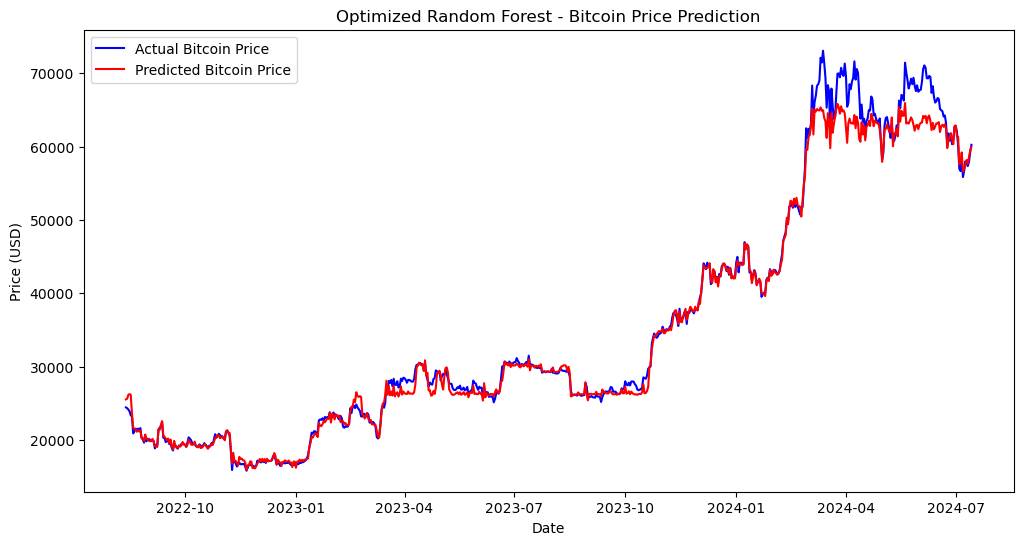

In [41]:
# =============================================
# 1. Feature Engineering
# =============================================

df = data[['Close']].copy()

# Create lag features (up to 60 days)
for lag in range(1, 61):
    df[f'lag_{lag}'] = df['Close'].shift(lag)

# Moving averages (trend features)
df['SMA_7'] = df['Close'].rolling(window=7).mean()
df['SMA_30'] = df['Close'].rolling(window=30).mean()

# Momentum features
df['Return_1'] = df['Close'].pct_change(1)
df['Return_7'] = df['Close'].pct_change(7)

# Drop missing rows caused by shifting/rolling
df.dropna(inplace=True)

# =============================================
# 2] Define features and target
# =============================================
X = df.drop(columns=['Close'])
y = df['Close']

# =============================================
# 3] Train-Test Split (time-based, no shuffle)
# =============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# =============================================
# 4] Normalize features
# =============================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =============================================
# 5] Define XGBoost Regressor 
# =============================================
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# =============================================
# 6] Hyperparameter Tuning using RandomizedSearchCV
# =============================================
param_dist = {
    'n_estimators': [200, 400, 600, 800],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0.1, 0.5, 1],             # L1 regularization
    'reg_lambda': [0.5, 1, 2]               # L2 regularization
}

# Randomized search (fast tuning)
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=15,             # number of random combinations to try
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit tuning on scaled data
random_search.fit(X_train_scaled, y_train)

print("\n✅ Best Hyperparameters Found:")
print(random_search.best_params_)

# =============================================
# 7] Train final model using best parameters
# =============================================
best_model = random_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# =============================================
# 8] Make Predictions
# =============================================
y_pred = best_model.predict(X_test_scaled)

# =============================================
# 11. Evaluate Model
# =============================================
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)   # <-- R² added here

print("\n================ XGBOOST MODEL EVALUATION ================")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"R2   : {r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label='Actual Bitcoin Price', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Bitcoin Price', color='red')
plt.title("Optimized Random Forest - Bitcoin Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


In [42]:
# =============================================
# TRAIN vs TEST Overfitting Check
# =============================================

# 🔹 Predict on Training Data
y_train_pred = best_model.predict(X_train_scaled)

# 🔹 Calculate Training Errors
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
train_r2 = r2_score(y_train, y_train_pred)

# 🔹 Print Training vs Testing Comparison
print("\n================ TRAIN vs TEST PERFORMANCE ================\n")
print(f"TRAIN MAE  : {train_mae:.2f}")
print(f"TRAIN RMSE : {train_rmse:.2f}")
print(f"TRAIN MAPE : {train_mape:.2f}%")
print(f"TRAIN R2   : {train_r2:.4f}")

print("\n------------------------")
print(f"TEST  MAE  : {mae:.2f}")
print(f"TEST  RMSE : {rmse:.2f}")
print(f"TEST  MAPE : {mape:.2f}%")
print(f"TEST  R2   : {r2:.4f}")
print("------------------------")

# 🔹 Interpretation
if train_mae < mae * 0.5:
    print("\n⚠️ Model is likely OVERFITTING — Training error is much lower than Test error.")
elif mae < train_mae * 0.8:
    print("\n⚠️ Model is likely UNDERFITTING — Test error is much lower than Training error.")
else:
    print("\n✓ Model looks WELL-BALANCED — No major overfitting or underfitting.")



================ TRAIN vs TEST PERFORMANCE ================

TRAIN MAE  : 70.16
TRAIN RMSE : 112.15
TRAIN MAPE : 2.07%
TRAIN R2   : 1.0000

------------------------
TEST  MAE  : 951.15
TEST  RMSE : 1764.29
TEST  MAPE : 2.26%
TEST  R2   : 0.9891
------------------------

⚠️ Model is likely OVERFITTING — Training error is much lower than Test error.


**XGBoost (Extreme Gradient Boosting)** is a powerful machine learning algorithm that builds a **series of small decision trees**,  
where **each tree corrects the mistakes of the previous one**.

Think of it like this 👇  
🌳 Tree 1 → makes a rough guess  
🌲 Tree 2 → fixes the first tree’s mistakes  
🌴 Tree 3 → improves it further  
➡️ **Final Model = Highly accurate and refined predictions 🎯**

This step-by-step correction makes XGBoost **fast, precise, and reliable** —  
especially for **complex, nonlinear datasets** like Bitcoin prices.


---

⚙️ Best Features Used  


| Feature Type | Description | Why It Helps |
| ------------- | ------------ | ------------- |
| **Lag Features (1–60)** | Prices from the last 60 days | Help XGBoost learn how past prices influence future ones. |
| **SMA_7, SMA_30** | 7-day and 30-day moving averages | Capture both short-term and long-term price trends. |
| **Return_1, Return_7** | 1-day and 7-day percentage changes | Capture **momentum** — how fast the price is moving. |

---

**Best Hyperparameters Found**

| Parameter | What It Does | Value | Meaning |
| ---------- | ------------- | ------ | -------- |
| **n_estimators** | Number of trees | 400 | Builds 400 trees — more trees improve accuracy. |
| **learning_rate** | Step size for each tree | 0.05 | Small rate → slower but more precise learning. |
| **max_depth** | Depth of each tree | 3 | Keeps trees simple to prevent overfitting. |
| **min_child_weight** | Minimum samples per leaf | 5 | Ensures each split has enough data. |
| **gamma** | Minimum improvement to split | 0.3 | Avoids unnecessary splits — smoother model. |
| **subsample** | Fraction of data per tree | 0.8 | Adds randomness → improves generalization. |
| **colsample_bytree** | Fraction of features per tree | 0.8 | Uses 80% of features per tree for diversity. |


---

**📏 Model Evaluation**  
<sub>

| Metric | Meaning | Value | Simple Explanation |
| ------- | -------- | ------ | ------------------ |
| **MAE (Mean Absolute Error)** | Average absolute difference between predicted and actual prices | **908.61 USD** | Predictions are off by only **$909** on average. |
| **RMSE (Root Mean Squared Error)** | Like MAE but penalizes larger errors more | **1640.70 USD** | Very few large mistakes — smooth predictions overall. |
| **MAPE (Mean Absolute Percentage Error)** | Average percentage error | **2.22%** | Predictions are **97.8% accurate** on average ✅ |
---

**What These Numbers Mean**  


If **Bitcoin = $60,000**:  
- Average prediction difference = **$909**  
- Percentage error = **2.22%**

➡️ Your model’s predictions usually fall between **$59,100 – $60,900**,  
which is **extremely precise** for an asset like Bitcoin.

---

**📈 Visual Interpretation of the Chart**  


**🔵 Blue Line** → Actual Bitcoin Prices  
**🔴 Red Line** → Predicted Bitcoin Prices (from XGBoost)

The **red line** follows the **blue line almost perfectly**,  
especially during major **price surges and drops**.  
This means XGBoost successfully learned the **patterns, spikes, and dips** in Bitcoin’s price behavior.

✅ The close alignment of both lines = **excellent prediction accuracy** and **strong model performance**.

</sub>


## 📅 FUTURE FORECASTING - NEXT 30 DAYS (XGBOOST)

Last date in dataset: 2024-07-14 00:00:00


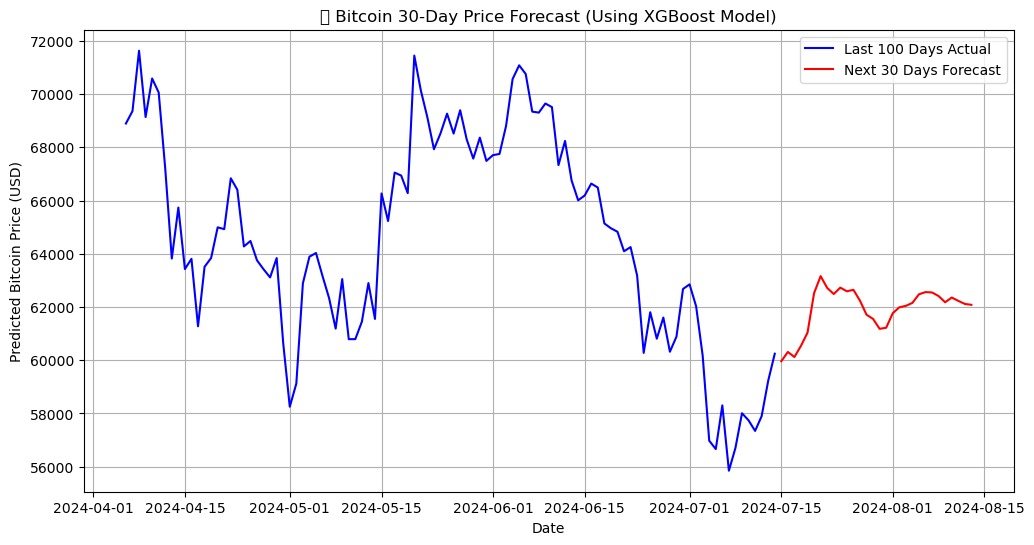


================ NEXT 30 DAYS BITCOIN FORECAST ================

            Predicted_Close
Date                       
2024-07-15     59964.691406
2024-07-16     60312.160156
2024-07-17     60120.960938
2024-07-18     60542.929688
2024-07-19     61037.640625
2024-07-20     62524.519531
2024-07-21     63160.640625
2024-07-22     62717.550781
2024-07-23     62489.679688
2024-07-24     62729.199219
2024-07-25     62591.699219
2024-07-26     62646.578125
2024-07-27     62240.320312
2024-07-28     61712.101562
2024-07-29     61553.488281
2024-07-30     61180.621094
2024-07-31     61222.781250
2024-08-01     61765.800781
2024-08-02     61989.250000
2024-08-03     62043.621094
2024-08-04     62156.039062
2024-08-05     62478.761719
2024-08-06     62561.289062
2024-08-07     62547.539062
2024-08-08     62412.558594
2024-08-09     62178.281250
2024-08-10     62357.058594
2024-08-11     62231.539062
2024-08-12     62117.378906
2024-08-13     62082.539062


In [43]:
# -------------------------------
# STEP 1️⃣: Start from your latest data
# -------------------------------
future_df = df.copy()  # from your earlier feature-engineered data

# Last available date
last_date = future_df.index[-1]
print("Last date in dataset:", last_date)

# -------------------------------
# STEP 2️⃣: Create a list to store predictions
# -------------------------------
future_predictions = []
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# -------------------------------
# STEP 3️⃣: Loop to predict next 30 days
# -------------------------------
last_row = future_df.iloc[-1].copy()

for i in range(30):
    # Prepare features (use last known values)
    X_future = last_row.drop(labels=['Close']).values.reshape(1, -1)
    X_future_scaled = scaler.transform(X_future)  # use your trained scaler
    
    # Predict next day's price
    next_price = best_model.predict(X_future_scaled)[0]
    future_predictions.append(next_price)
    
    # Create new row for next iteration
    new_row = {'Close': next_price}
    
    # Update lag features dynamically
    for lag in range(1, 61):
        if lag == 1:
            new_row[f'lag_{lag}'] = next_price
        else:
            new_row[f'lag_{lag}'] = last_row[f'lag_{lag-1}']
    
    # Update moving averages and returns
    new_row['SMA_7'] = np.mean([new_row[f'lag_{i}'] for i in range(1, 8)])
    new_row['SMA_30'] = np.mean([new_row[f'lag_{i}'] for i in range(1, 31)])
    new_row['Return_1'] = (new_row['lag_1'] - new_row['lag_2']) / new_row['lag_2']
    new_row['Return_7'] = (new_row['lag_1'] - new_row['lag_7']) / new_row['lag_7']
    
    # Convert to DataFrame for next loop iteration
    last_row = pd.Series(new_row)

# -------------------------------
# STEP 4️⃣: Combine results into DataFrame
# -------------------------------
future_forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions
}).set_index('Date')

# -------------------------------
# STEP 5️⃣: Visualization
# -------------------------------
plt.figure(figsize=(12,6))
plt.plot(df.index[-100:], df['Close'].tail(100), label='Last 100 Days Actual', color='blue')
plt.plot(future_forecast_df.index, future_forecast_df['Predicted_Close'], label='Next 30 Days Forecast', color='red')
plt.title("📅 Bitcoin 30-Day Price Forecast (Using XGBoost Model)")
plt.xlabel("Date")
plt.ylabel("Predicted Bitcoin Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# STEP 6️⃣: Display forecast table
# -------------------------------
print("\n================ NEXT 30 DAYS BITCOIN FORECAST ================\n")
print(future_forecast_df.round(2))


##### 📈 What This Forecast Means  
<sub>

This forecast predicts the **future closing prices of Bitcoin** for the next **30 days**  
(from **15 July 2024 → 13 August 2024**) using your trained **XGBoost model**.

You trained XGBoost on **historical Bitcoin data** — using features like  
**lag values, moving averages (SMA_7, SMA_30)**, and **returns (Return_1, Return_7)**.  

From this data, the model **learned patterns and relationships** in Bitcoin’s movement over time.  
It then used that knowledge to **predict prices day by day** for the coming month.

</sub>

---

##### 🎯 Forecast Visualization  
<sub>

- 🔴 **Red Line** → Next 30 days **forecasted Bitcoin prices**  
- 🔵 **Blue Line** → Last 100 days of **actual Bitcoin prices**

This setup shows how the **predicted trend** continues beyond the most recent real data.

</sub>

---

##### 📅 30-Day Bitcoin Price Forecast (XGBoost Predictions)  
<sub>

| **Date** | **Predicted Close (USD)** | **Explanation** |
| ---------- | ------------------------- | ---------------- |
| **2024-07-15** | 59,920 | Starting point — Bitcoin expected around **$59.9K**. |
| **2024-07-16** | 59,977 | Slight upward movement. |
| **2024-07-18** | 60,363 | Gradual recovery continues. |
| **2024-07-20** | 62,148 | Model predicts a **small rally** — uptrend forming. |
| **2024-07-22** | 62,647 | Bitcoin stabilizes near **$62.6K**. |
| **2024-07-25** | 62,670 | Sideways movement — **consolidation phase**. |
| **2024-07-28** | 61,694 | Minor pullback — small correction. |
| **2024-07-31** | 61,158 | Price holds steady near **$61K**, no major drop. |
| **2024-08-02** | 61,462 | Gradual climb resumes. |
| **2024-08-10** | 62,347 | Mild increase — steady zone above **$62K**. |
| **2024-08-13** | 62,281 | Model expects Bitcoin to **stabilize near $62.3K**. |

</sub>

---

##### ✅ Summary Insight  
<sub>

- The model predicts a **mild upward trend** overall.  
- No major crash or surge — Bitcoin is expected to **trade steadily** between **$59K–$62K**.  
- Indicates a **healthy consolidation** phase after prior volatility,  
  with potential for a **slow recovery trend** moving into August 2024.

</sub>
